For this project, you're going to select a dataset of your choosing and create a classification model. You'll start by identifying a problem you can solve with classification, and then identify a dataset. You'll then use everything you've learned about Data Science and Machine Learning thus far to source a dataset, preprocess and explore it, and then build and interpret a classification model that answers your chosen question.

steps
1. import libraries/packages
2. import data
3. inspect data
4. clean data 
4a. do I need to convert lat/long to location? 
        if no, drop lat, long and is_geocoding_exact
5. standardize? 
6. scaling/transformation
7. normalize? 
8. test/train split and random state
9. vanilla tree
9A. feature importance 
10. model performance and accuracy
grid search
examine best param
11. random forests
bagged trees 

pipelines

need dummies
    pd.get_dummies
create armed or no variable? 
dummies for whole dataset or just bool expressions? 
group by states 

https://github.com/cphalpert/census-regions
https://github.com/washingtonpost/data-police-shootings

In [562]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

if i decide to come back and map coordinates 

import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import plotly_express as px
import tqdm
from tqdm.notebook import tqdm_notebook

In [563]:
df = pd.read_csv('fatal-police-shootings-data.csv')

In [564]:
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


dropping name and id column 

In [565]:
df = df.drop(['name', 'id'], axis=1)

In [566]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5740 entries, 0 to 5739
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     5740 non-null   object 
 1   manner_of_death          5740 non-null   object 
 2   armed                    5527 non-null   object 
 3   age                      5479 non-null   float64
 4   gender                   5739 non-null   object 
 5   race                     5123 non-null   object 
 6   city                     5740 non-null   object 
 7   state                    5740 non-null   object 
 8   signs_of_mental_illness  5740 non-null   bool   
 9   threat_level             5740 non-null   object 
 10  flee                     5446 non-null   object 
 11  body_camera              5740 non-null   bool   
 12  longitude                5458 non-null   float64
 13  latitude                 5458 non-null   float64
 14  is_geocoding_exact      

converting bool to int 
dropping geocoding rows with inaccurate lat/long info 

In [567]:
df = df[df.is_geocoding_exact != 'False']

In [568]:
df = df.applymap(lambda x: 1 if x == True else x)
df = df.applymap(lambda x: 0 if x == False else x)

In [569]:
df.isna().sum()

date                         0
manner_of_death              0
armed                      213
age                        261
gender                       1
race                       617
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                       294
body_camera                  0
longitude                  282
latitude                   282
is_geocoding_exact           0
dtype: int64

dropping nan values and filling others 

In [570]:
df = df.dropna(subset=['age', 'longitude', 'latitude', 'flee'])

In [571]:
values = {'race': 'U', 'armed': 'undetermined'}
df = df.fillna(value=values)

In [572]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4958 entries, 0 to 5739
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     4958 non-null   object 
 1   manner_of_death          4958 non-null   object 
 2   armed                    4958 non-null   object 
 3   age                      4958 non-null   float64
 4   gender                   4958 non-null   object 
 5   race                     4958 non-null   object 
 6   city                     4958 non-null   object 
 7   state                    4958 non-null   object 
 8   signs_of_mental_illness  4958 non-null   int64  
 9   threat_level             4958 non-null   object 
 10  flee                     4958 non-null   object 
 11  body_camera              4958 non-null   int64  
 12  longitude                4958 non-null   float64
 13  latitude                 4958 non-null   float64
 14  is_geocoding_exact      

In [573]:
df.isna().sum()

date                       0
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
city                       0
state                      0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
longitude                  0
latitude                   0
is_geocoding_exact         0
dtype: int64

In [574]:
display(df.describe())

,age,signs_of_mental_illness,body_camera,longitude,latitude,is_geocoding_exact
count,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000
mean,36.988705,0.240420,0.123840,-97.038840,36.708355,0.998386
std,13.038802,0.427381,0.329432,16.622702,5.356200,0.040141
min,6.000000,0.000000,0.000000,-158.137000,19.498000,0.000000
25%,27.000000,0.000000,0.000000,-112.072000,33.490750,1.000000
50%,35.000000,0.000000,0.000000,-94.003000,36.159500,1.000000
75%,45.000000,0.000000,0.000000,-82.995500,39.993750,1.000000
max,91.000000,1.000000,1.000000,-68.014000,71.301000,1.000000


In [575]:
df['threat_level'].unique()
df['flee'].unique()

array(['Not fleeing', 'Car', 'Foot', 'Other'], dtype=object)

In [576]:
df['manner_of_death'].unique()

array(['shot', 'shot and Tasered'], dtype=object)

create new armed column? armed with lethal weapon - true/false? or unarmed v. armed? 

In [577]:
df['armed'].value_counts()

gun             2814
knife            725
unarmed          334
undetermined     319
toy weapon       179
                ... 
stapler            1
glass shard        1
air pistol         1
bean-bag gun       1
garden tool        1
Name: armed, Length: 92, dtype: int64

In [578]:
pie_me = df['armed'].value_counts().reset_index()
pie_me.columns = ['armed', 'count']

fig = px.pie(
    pie_me, 
    values='count', 
    names='armed',  
    title='Weapon distribution', 
    width=600, 
    height=600
)

fig.show()

In [579]:
#converting armed values with a count of less than 59 into 'other'
df[['armed']] = df[['armed']].where(df.apply(lambda x: x.groupby(x).transform('count')>59), 'other')

In [580]:
df['armed'].value_counts()

gun             2814
knife            725
other            445
unarmed          334
undetermined     319
toy weapon       179
vehicle          142
Name: armed, dtype: int64

importing df to merge states and base data on divisions

In [581]:
states = pd.read_csv('us census bureau regions and divisions.csv')
states.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [582]:
states = states.drop(['State'], axis=1)

In [583]:
states = states.rename(columns={"State Code": "state"})

In [584]:
rougher_df = pd.merge(states, df, on='state')
rougher_df.head()

,state,Region,Division,date,manner_of_death,armed,age,gender,race,city,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,AK,West,Pacific,2015-02-08,shot,gun,33.0,M,W,Anchorage,0,attack,Car,0,-149.859,61.208,1
1,AK,West,Pacific,2015-09-08,shot,gun,19.0,M,N,Fairbanks,0,attack,Not fleeing,0,-147.779,64.827,1
2,AK,West,Pacific,2015-09-09,shot,gun,33.0,M,N,Fairbanks,0,attack,Car,0,-147.543,64.806,1
3,AK,West,Pacific,2015-10-24,shot,undetermined,49.0,M,W,Kenai Peninsula,0,attack,Not fleeing,0,-151.283,60.287,1
4,AK,West,Pacific,2016-01-12,shot,knife,49.0,M,N,Spenard,1,other,Not fleeing,0,-149.898,61.192,1


creating df without state, region, city, long, lat, is geocoding exact, and date

to include or not include lat, long, geocoding? 

In [585]:
no_locdf = rougher_df.drop(['state', 'Region', 'city'], axis=1)
no_locdf.head()

,Division,date,manner_of_death,armed,age,gender,race,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,Pacific,2015-02-08,shot,gun,33.0,M,W,0,attack,Car,0,-149.859,61.208,1
1,Pacific,2015-09-08,shot,gun,19.0,M,N,0,attack,Not fleeing,0,-147.779,64.827,1
2,Pacific,2015-09-09,shot,gun,33.0,M,N,0,attack,Car,0,-147.543,64.806,1
3,Pacific,2015-10-24,shot,undetermined,49.0,M,W,0,attack,Not fleeing,0,-151.283,60.287,1
4,Pacific,2016-01-12,shot,knife,49.0,M,N,1,other,Not fleeing,0,-149.898,61.192,1


In [586]:
dummydf = pd.get_dummies(no_locdf)
dummydf.head()

,age,signs_of_mental_illness,body_camera,longitude,latitude,is_geocoding_exact,Division_East North Central,Division_East South Central,Division_Middle Atlantic,Division_Mountain,...,race_O,race_U,race_W,threat_level_attack,threat_level_other,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,flee_Other
0,33.0,0,0,-149.859,61.208,1,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
1,19.0,0,0,-147.779,64.827,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,33.0,0,0,-147.543,64.806,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,49.0,0,0,-151.283,60.287,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
4,49.0,1,0,-149.898,61.192,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [587]:
y = dummydf['signs_of_mental_illness']
X = dummydf.drop('signs_of_mental_illness', axis=1)

In [588]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

initial decision tree analysis 

In [589]:
regressor = DecisionTreeRegressor(random_state=42)  
regressor.fit(X_train, y_train)  

DecisionTreeRegressor(random_state=42)

create scatterplot to examine features 

MSE lower with location data omitted 

In [590]:
y_pred = regressor.predict(X_test) 

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.2842741935483871
Mean Squared Error: 0.2842741935483871
Root Mean Squared Error: 0.5331736992279225


In [591]:
dt_clf = DecisionTreeClassifier()

In [592]:
dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 70.90%


depth can lead to overfitting

In [593]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [594]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [595]:
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 79.19%
Mean Test Score: 75.30%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [596]:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 75.90%


In [597]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [598]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 76.12%

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 10}


In [599]:
dt_score = dt_grid_search.score(X_test, y_test)
rf_score = rf_grid_search.score(X_test, y_test)

print('Decision tree grid search: ', dt_score)
print('Random forest grid search: ', rf_score)

Decision tree grid search:  0.7530241935483871
Random forest grid search:  0.7530241935483871


In [600]:
#y = df['signs_of_mental_illness']
#X = df.drop('signs_of_mental_illness', axis=1)


In [601]:
#ddf = pd.get_dummies(df, prefix=['signs_of_mental_illness', 'body_camera', ''])

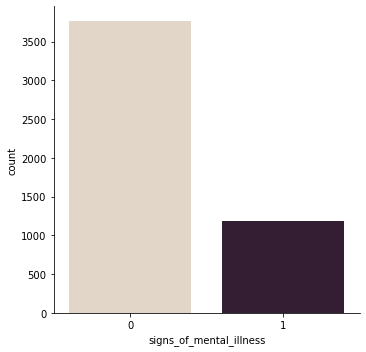

In [602]:
sns.catplot(x="signs_of_mental_illness", kind="count", palette="ch:.25", data=df)

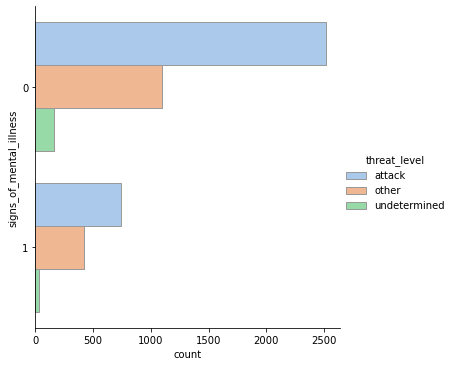

In [603]:
sns.catplot(y="signs_of_mental_illness", hue="threat_level", kind="count",
            palette="pastel", edgecolor=".6",
            data=df)

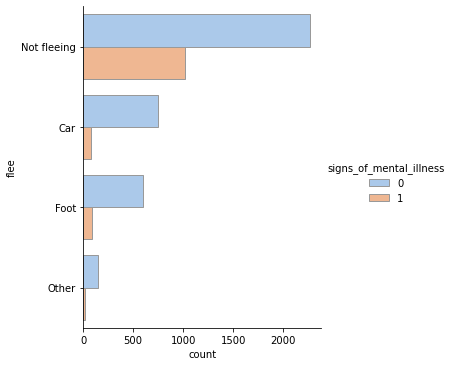

In [604]:
sns.catplot(y="flee", hue="signs_of_mental_illness", kind="count",
            palette="pastel", edgecolor=".6",
            data=df)

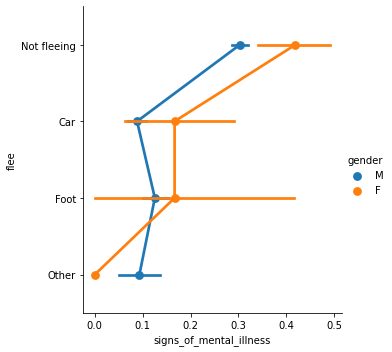

In [605]:
sns.catplot(x="signs_of_mental_illness", y="flee", hue="gender", kind="point", data=df)

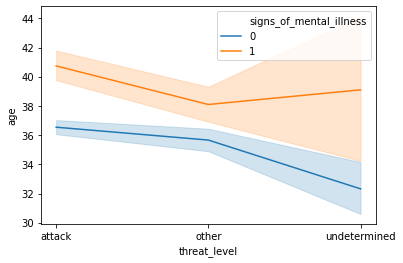

In [606]:
sns.lineplot(x='threat_level', y='age', data=df, hue='signs_of_mental_illness')

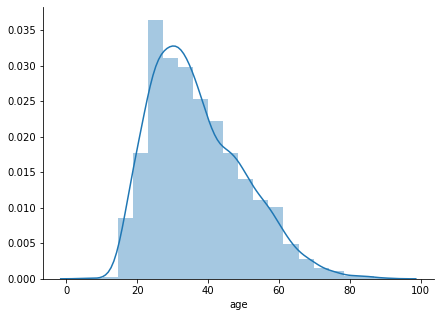

In [607]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.distplot(df['age'], bins=20)

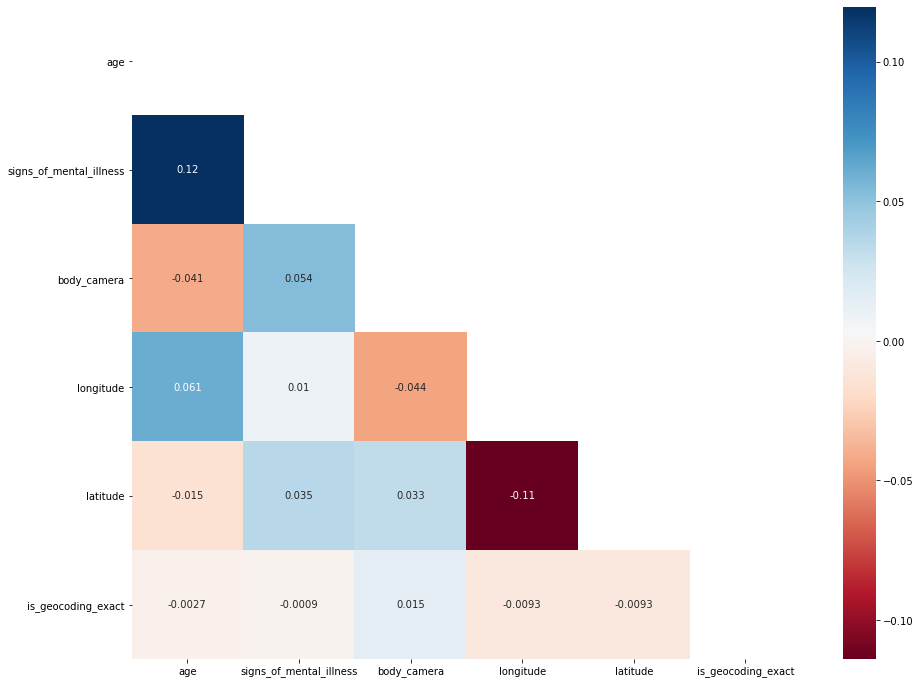

In [608]:
plt.figure(figsize=(15,12))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask,
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap='RdBu', annot = True)